1. Sobald eine Methode zur Dimensionsreduktion trainiert wurde, kann man dann auch diese Operation r ̈uckg ̈angig
machen?

Solange wir die Hauptachsten haben (und solange *span* von diesen Hauptachsen die Dimensionen des originalen Datensatzes entspricht; also solange keine Dimension verloren gegangen ist) können wir die Reduktion immer rückgängig machen, den originalen Datensatz wieder neu produzieren.

Also, wenn $Z = X V_d \in \mathbb{R}^{m x d}$, dann

$$ \hat{X} =  Z V_d^{T} = X \underbrace{V_d V_d^{T}}_I$$ 

2. Macht es Sinn zwei verschiedene Methoden zur Dimensionsreduktion hintereinander auszuf ̈uhren?

Es kann nützlich sein zuerst mit PCA die weniger wichtigen Dimensionen (die Dimensionen, die weniger Varianz erklären) entfernen und dann mit LLE eine sogar niedriger dimensionale Darstellung des übrig gebliebenen Datensatzes zu finden.

3. Angenommen man reduziert mittels PCA die Dimension eines 1000-dimensionalen Datensatzes, sodass 95%
der Varianz erkl ̈art wird. Auf welche Dimension wird sich der Datensatz reduzieren?

Ohne zu wissen wie viel Varianz jede Dimension erklärt können wir es nicht wissen. Wir können das mit einer kumulativen Berechnung der erklärten Varianzen der Dimensionen berechnen.

4. Wie kann man die Performance einer Methode zur Dimensionsreduktion messen?

Wie gut die Rücktransformation den originalen Datensatz präsentiert sieht man schon von der erklärten Varianz nach der Dimensionsreduktion. Die weitere Leistung erfahrt man mit der Leistung des Models mit den reduzierten Dimensionen.

5. Was ist der Unterschied zwischen Hard und Soft Voting?

Beim Hard-Voting wird die Klasse vorhergesagt, die die meisten Stimme aus dem Ensemble erhält, das ist einfach eine binäre Denkweise.
Beim Soft-Voting demgegenüber, wenn die Vorsagemodelle davon fähig sind eine Wahscheinlichkeit der Klassengehörigkeit zu liefern, wird vom Ensemble die Klasse mit höchster durchschnittlichen Wahrscheinlichkeit vorhergesagt. Darüber hinaus leistet Soft-Voting meistens besser.

# Dimensionsreduktion und Ensemble-Methoden

In dieser Übung werden wir uns der wichtigen Hauptkomponentenanalyse (*Principal Component Analysis* PCA) widmen und verschiedene Ensemble-Methoden verwenden, um ein Modell zur Gesichtserkennung zu entwickeln.
Dazu verwenden wir das *Olivetti-Faces* Datenset, welches aus 400 verschiedenen Bildern von 40 verschiedenen Personen besteht. Jedes Bild hat $64 \times 64$ Pixel.

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import fetch_olivetti_faces
faces, labels = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=42)

Um ein Bild zu plotten können wir `imshow` verwenden. Der folgende Code plottet jeweils das erste Gesicht der 40 verschiedenen Personen.

/var/folders/dz/bzxsk9tj3clf0cs7vg6r7h_80000gn/T/ipykernel_11451/4280281974.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


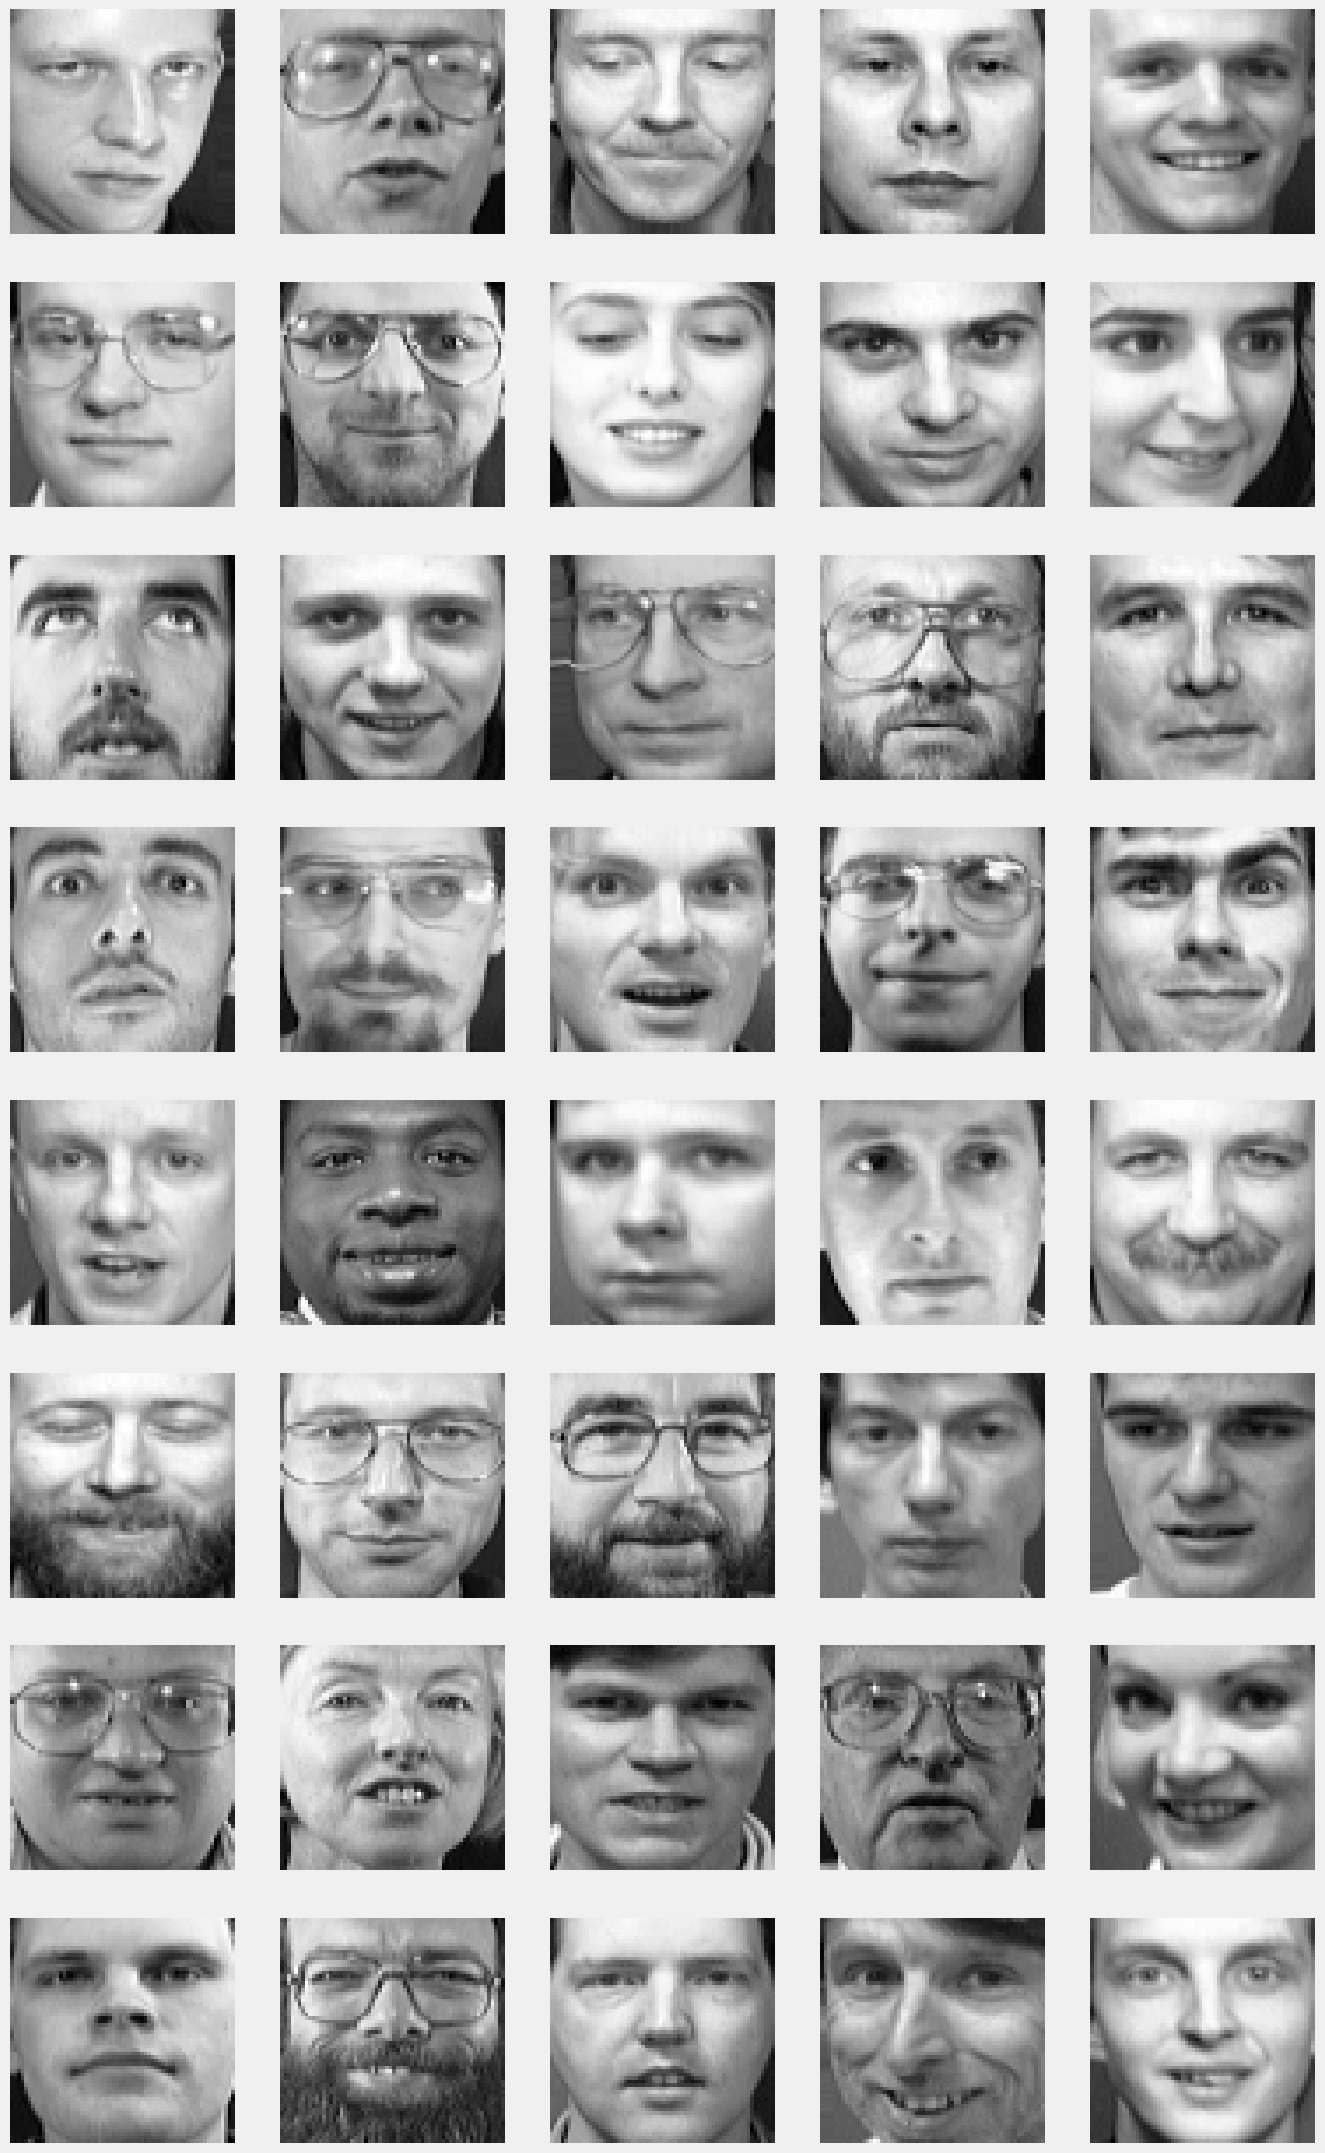

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def _plot_face(face):
    if face.shape != (64, 64):
        face = face.reshape(64, 64)
    plt.imshow(face, cmap='gray')
    plt.axis('off')

    
def plot_faces(faces, cols=4, title=""):
    faces = np.array(faces)
    if len(faces.shape) == 1:
        faces = faces[None, :]
    m = faces.shape[0]
    
    rows = m // cols
    if m % cols != 0:
        rows += 1
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    if len(axes.shape) == 1:
        axes = axes[None, :]
    
    for i in range(rows):
        for j in range(cols):
            try:
                plt.sca(axes[i, j])  # set current axes
                face = faces[i * cols + j]  # get face
            except IndexError:
                plt.axis('off')
                continue
            _plot_face(face)

    fig.suptitle(title)
    fig.subplots_adjust(top=0.96)
    
    return fig, axes

# plot all distinct persons
_, idx = np.unique(labels, return_index=True)
fig, _ = plot_faces(faces[idx], cols=5);
fig.savefig("faces_output.png", dpi=900)
fig.show()

## a) Eigengesichter
- Plotte die ersten 20 Hauptachsen (Eigenvektoren der Kovarianzmatrix). 

In [11]:
from sklearn.decomposition import PCA
from sklearn import preprocessing   # To try different scaling methods
import matplotlib.pyplot as plt
import pandas as pd


"Mean Face":

(<Figure size 1200x300 with 4 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

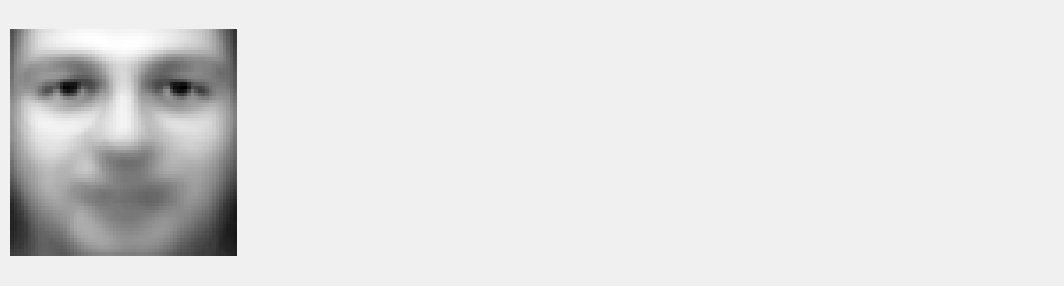

In [12]:
plot_faces(faces.mean(axis=0))

Zentrierere die Beobachtungen (vielleicht macht das das PCA-Model automatisch?)

In [13]:
faces_centered = faces - faces.mean(axis=0)
faces_centered -= faces_centered.mean(axis=1).reshape(len(faces), -1)

In [14]:
# Wähle die ersten 20 Hauptachsen
n_comp = 20
pca_model = PCA(n_components=n_comp) 
transformed_faces = pca_model.fit_transform(faces)
pca_model.explained_variance_.cumsum()  # Es wird ~60% Varianz erklärt 

# Macht der zentrierte Array einen Unterschied?
pca_model_centered = PCA(n_components=n_comp)
transformed_faces_centered = pca_model_centered.fit_transform(faces_centered)

# Und wie wäre es, wenn wir die Daten selbst skalieren und ohne transformation fitten?
scaled_faces = preprocessing.scale(faces)
pca_model_prescaled = PCA(n_components=n_comp)
pca_model_prescaled.fit(scaled_faces)

# Mit StandardScaler
std_scaled_faces = StandardScaler().fit_transform(faces)
pca_model_std_prescaled = PCA(n_components=n_comp)
pca_model_std_prescaled.fit(std_scaled_faces)


/Users/ubd/miniforge3/envs/data_science/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/Users/ubd/miniforge3/envs/data_science/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:259: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


PCA(n_components=20)

Visualisierungen der ersten 20 Hauptachsen der 3 Modellen:

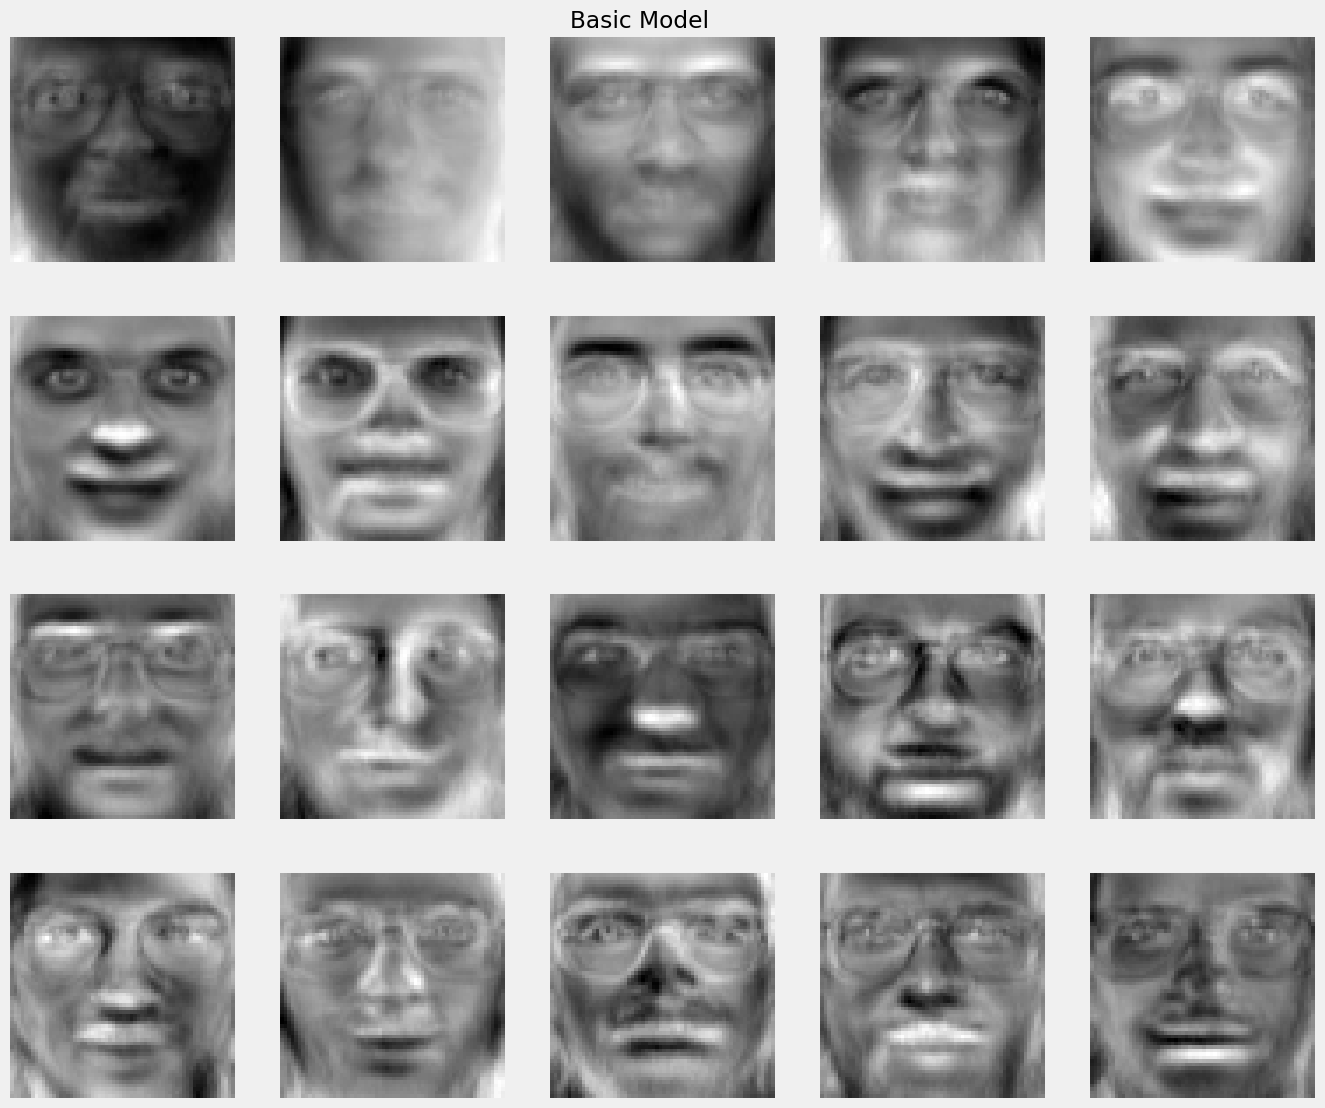

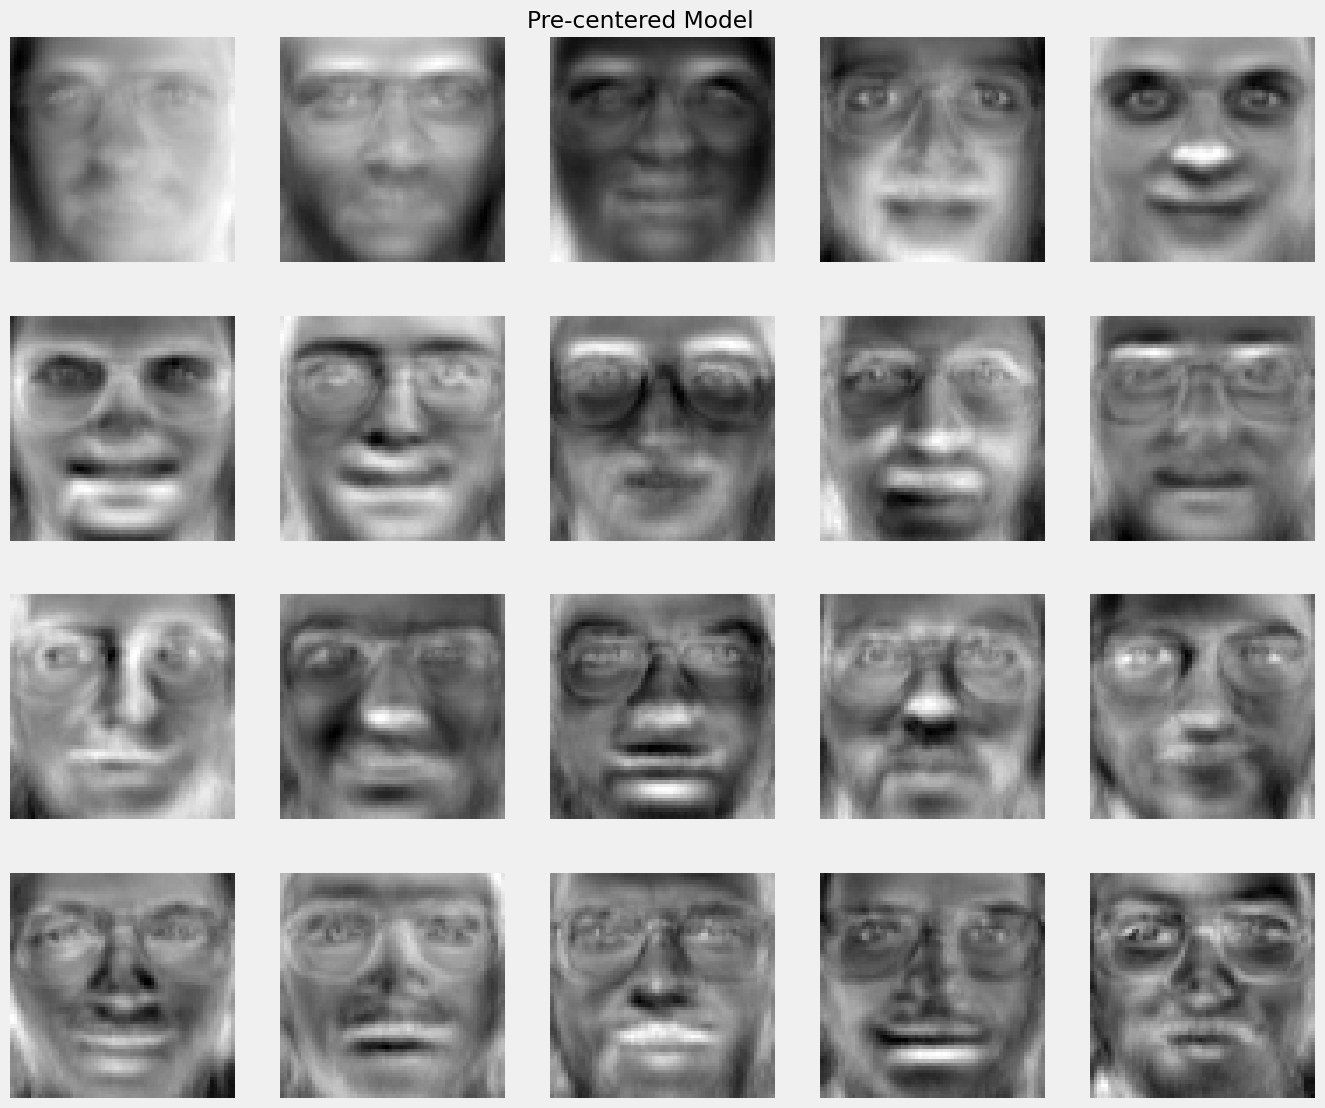

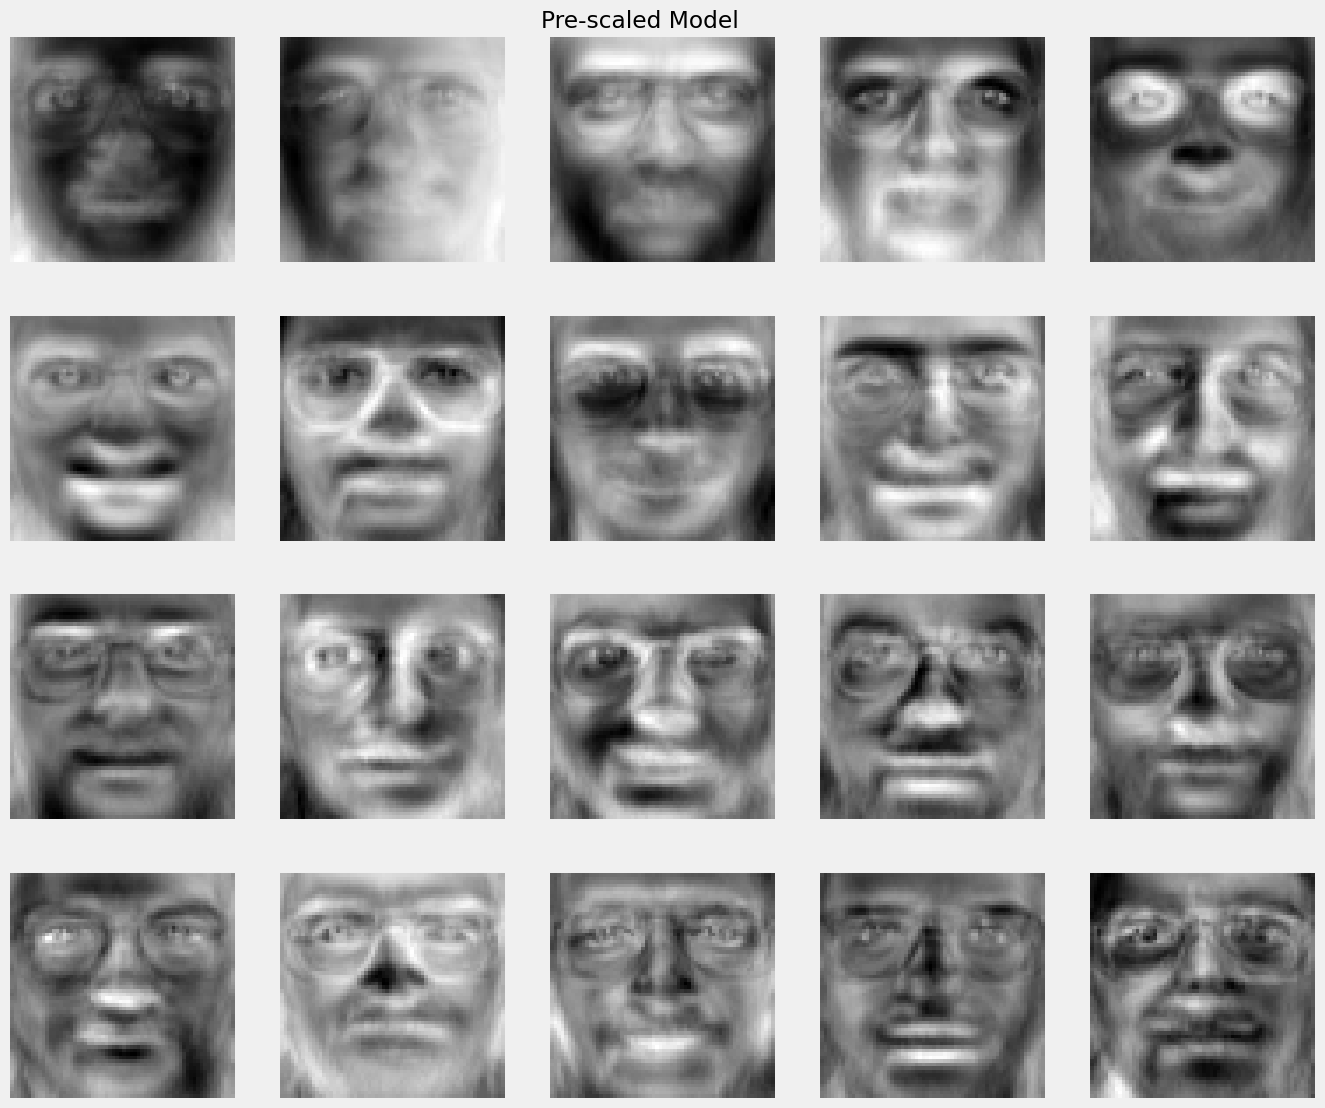

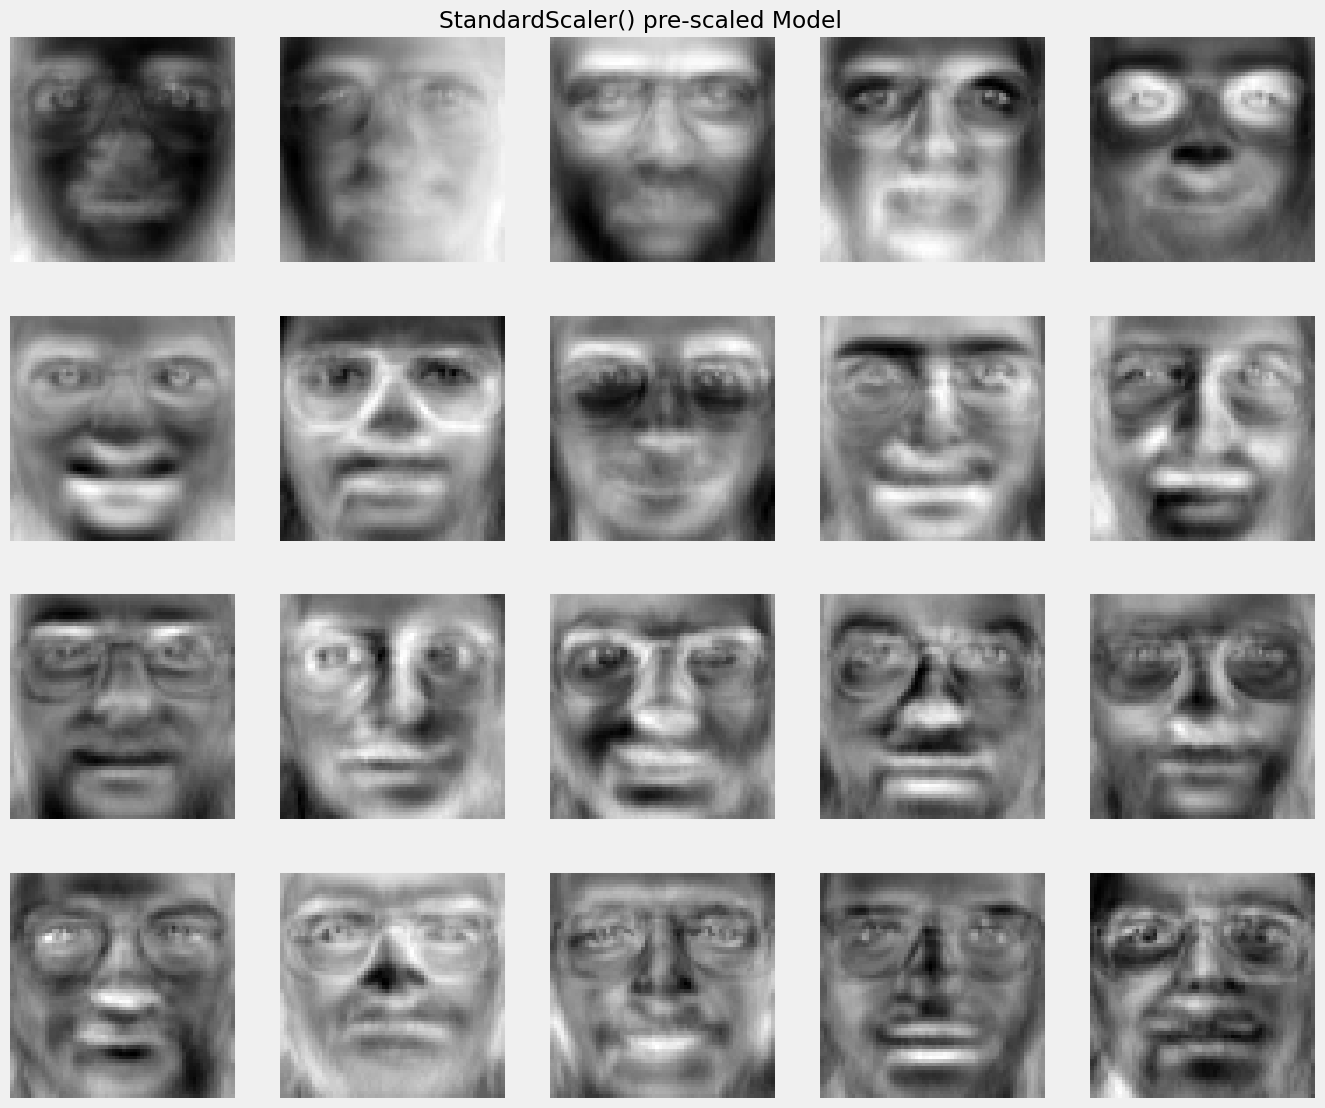

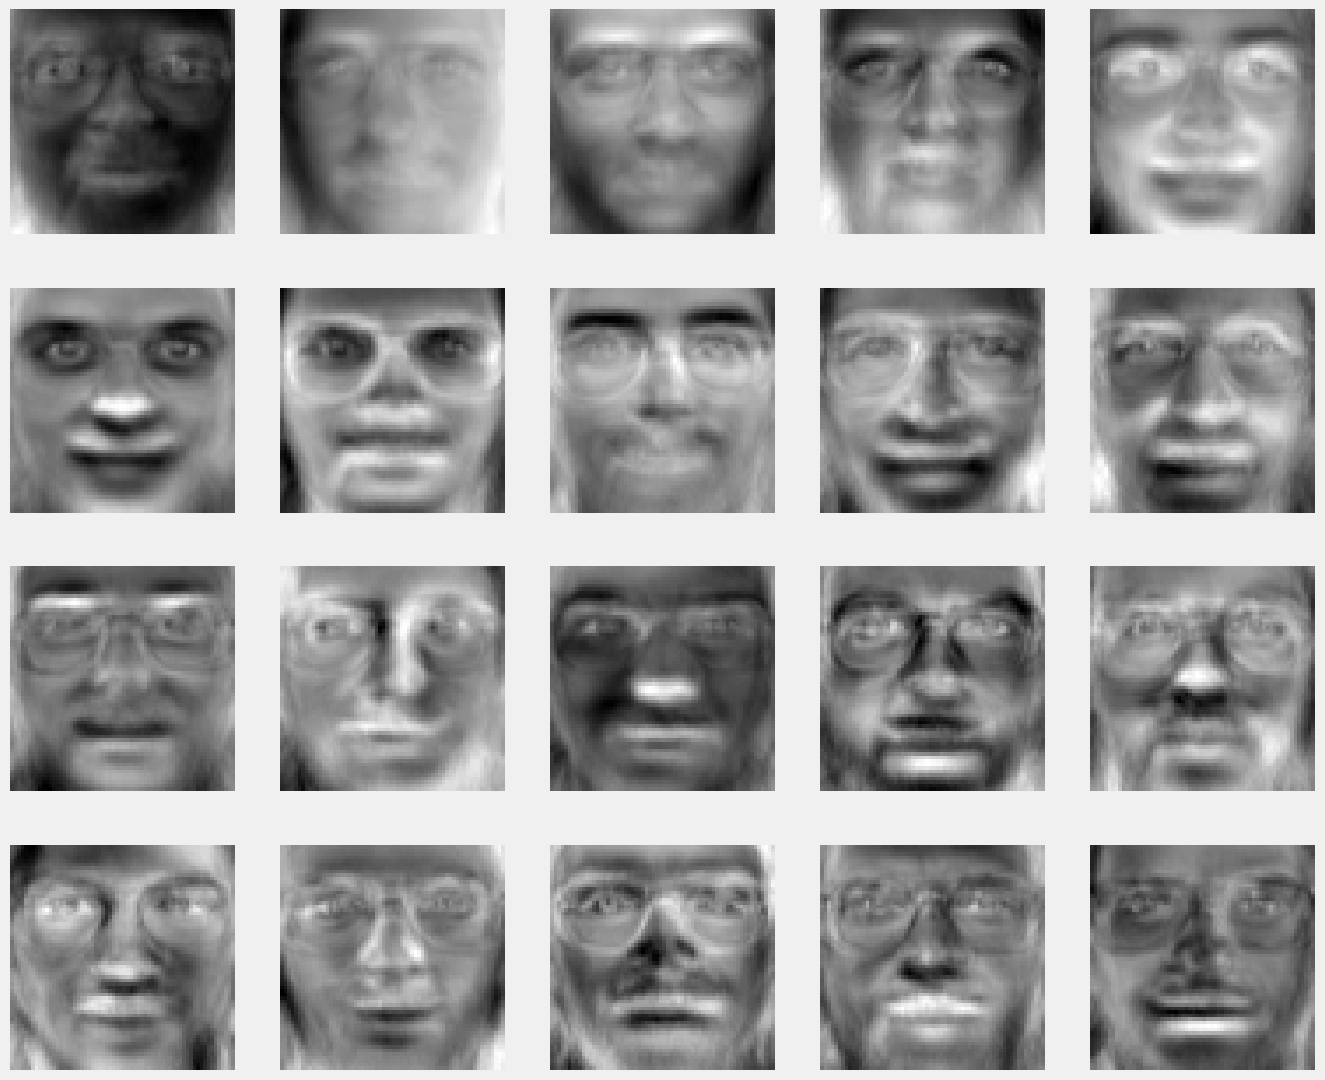

In [42]:
plot_faces(pca_model.components_, cols=5, title="Basic Model")
plot_faces(pca_model_centered.components_, cols=5, title="Pre-centered Model")
plot_faces(pca_model_prescaled.components_, cols=5, title="Pre-scaled Model")
plot_faces(pca_model_std_prescaled.components_, cols=5, title="StandardScaler() pre-scaled Model")
fig, _ = plot_faces(pca_model.components_, cols=5)
fig.savefig("faces_pca_with_20-main-components.png", dpi=900)


- Wie groß sind die zugehörigen Eigenwerte (Varianzen) dieser Eigengesichter?

Also, wir haben die obigen Eigenvektoren von der Kovarianzmatrix $X^TX$. Sei $v_k$ die Eigenvektoren und $\lambda_k$ die Eigenwerten für $k = 1, \ldots, \text{Anzahl der Komponenten}$. Dann;

$$X^TX v_k = \lambda_k v_k \implies \lambda_k = \ <X^TX v_k, v_k> \text{ mit } ||v_k||^2 = 1 $$

In [16]:
m = faces_centered.shape[0]     # Da wir hier manuell berechenen, 
                                # benutze ich einfach die zentrierten Daten. Sonst hätte ich wieder zentrieren müssen.
cov_matrix = np.dot(faces_centered.T, faces_centered) / m
for eigenvector in pca_model_centered.components_:
    print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))) 

11.265934
6.3150907
4.4085064
3.4729922
2.5249925
2.0739794
1.6218457
1.6049399
1.3355033
1.2621926
1.1349277
1.0094956
0.9488584
0.84323895
0.79162353
0.7420134
0.66886693
0.5949468
0.591858
0.56110865


Oder wir können mit der folgenden Methoder des PCA-Objekts dasselbe berechnen, weil die Eigenwerte genau der erklärten Varianz auf einem (durch einen?) Eigenvektor.

In [17]:
pca_model_centered.explained_variance_

array([11.29417   ,  6.3309135 ,  4.419554  ,  3.4816983 ,  2.5313213 ,
        2.079178  ,  1.6259085 ,  1.6089658 ,  1.3388513 ,  1.2653569 ,
        1.1377738 ,  1.0120245 ,  0.95123667,  0.84535146,  0.79360664,
        0.7438736 ,  0.6705439 ,  0.5964383 ,  0.59334135,  0.56251556],
      dtype=float32)

- Plotte den Anteil der erklärten Varianz in Abhängigkeit der verwendeten Hauptkomponenten. Dazu kannst du das Attribut `explained_variance_ratio_` verwenden.

In [18]:
pca_model_centered.explained_variance_ratio_

array([0.18154666, 0.10176544, 0.07104155, 0.0559661 , 0.04068939,
       0.03342148, 0.02613545, 0.02586311, 0.02152119, 0.02033981,
       0.01828899, 0.01626766, 0.01529053, 0.01358849, 0.01275673,
       0.0119573 , 0.01077857, 0.00958737, 0.00953759, 0.00904208],
      dtype=float32)

([<matplotlib.axis.XTick at 0x315478130>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

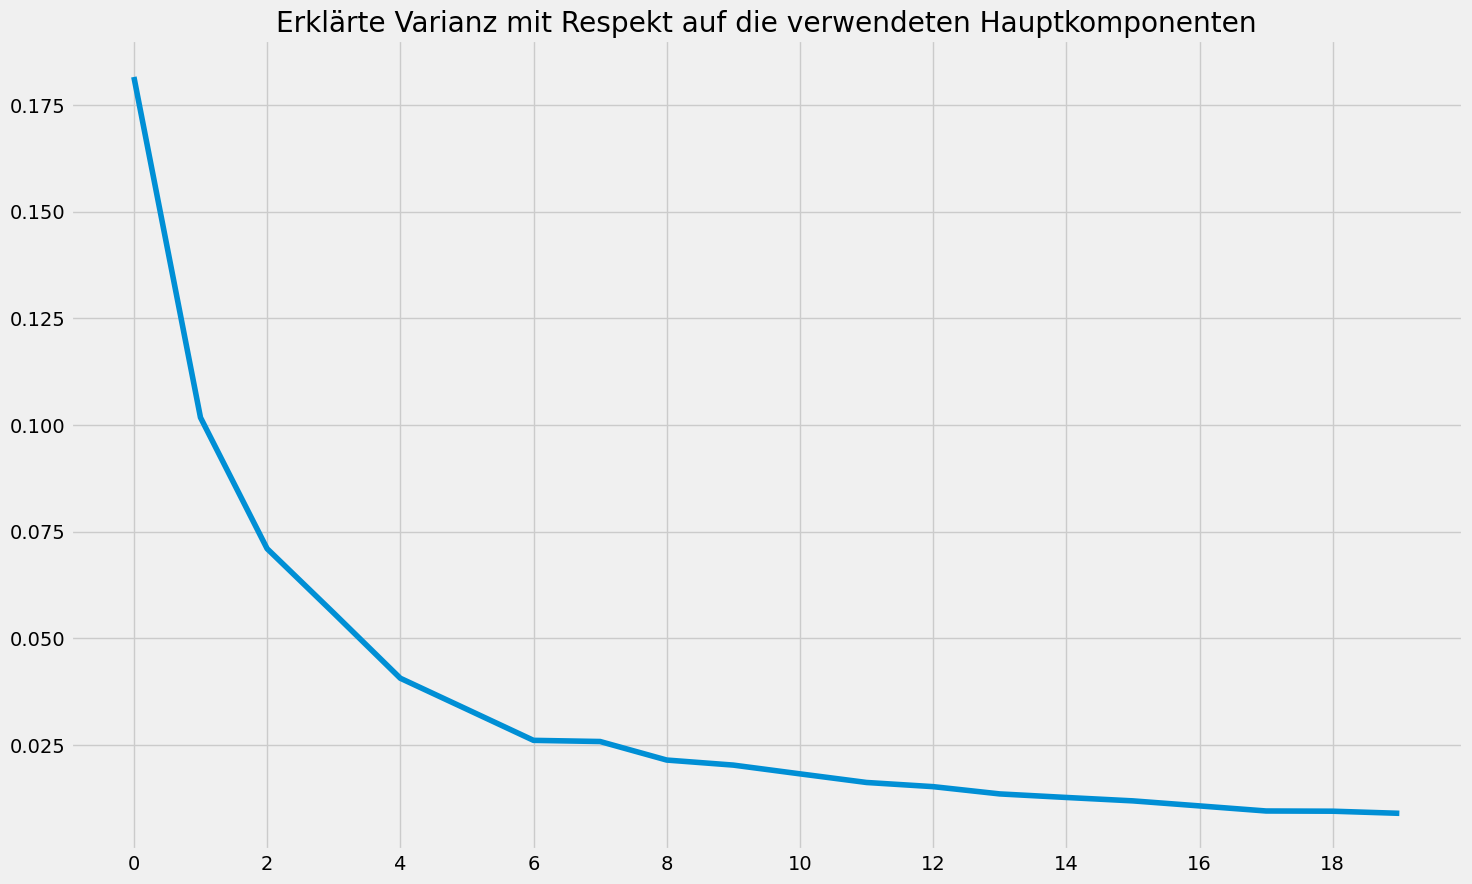

In [19]:
plt.figure(figsize=(16, 10))
plt.title('Erklärte Varianz mit Respekt auf die verwendeten Hauptkomponenten')
plt.plot(pca_model_centered.explained_variance_ratio_)
plt.xticks(np.arange(0, 20, step=2))

([<matplotlib.axis.XTick at 0x31950b8e0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

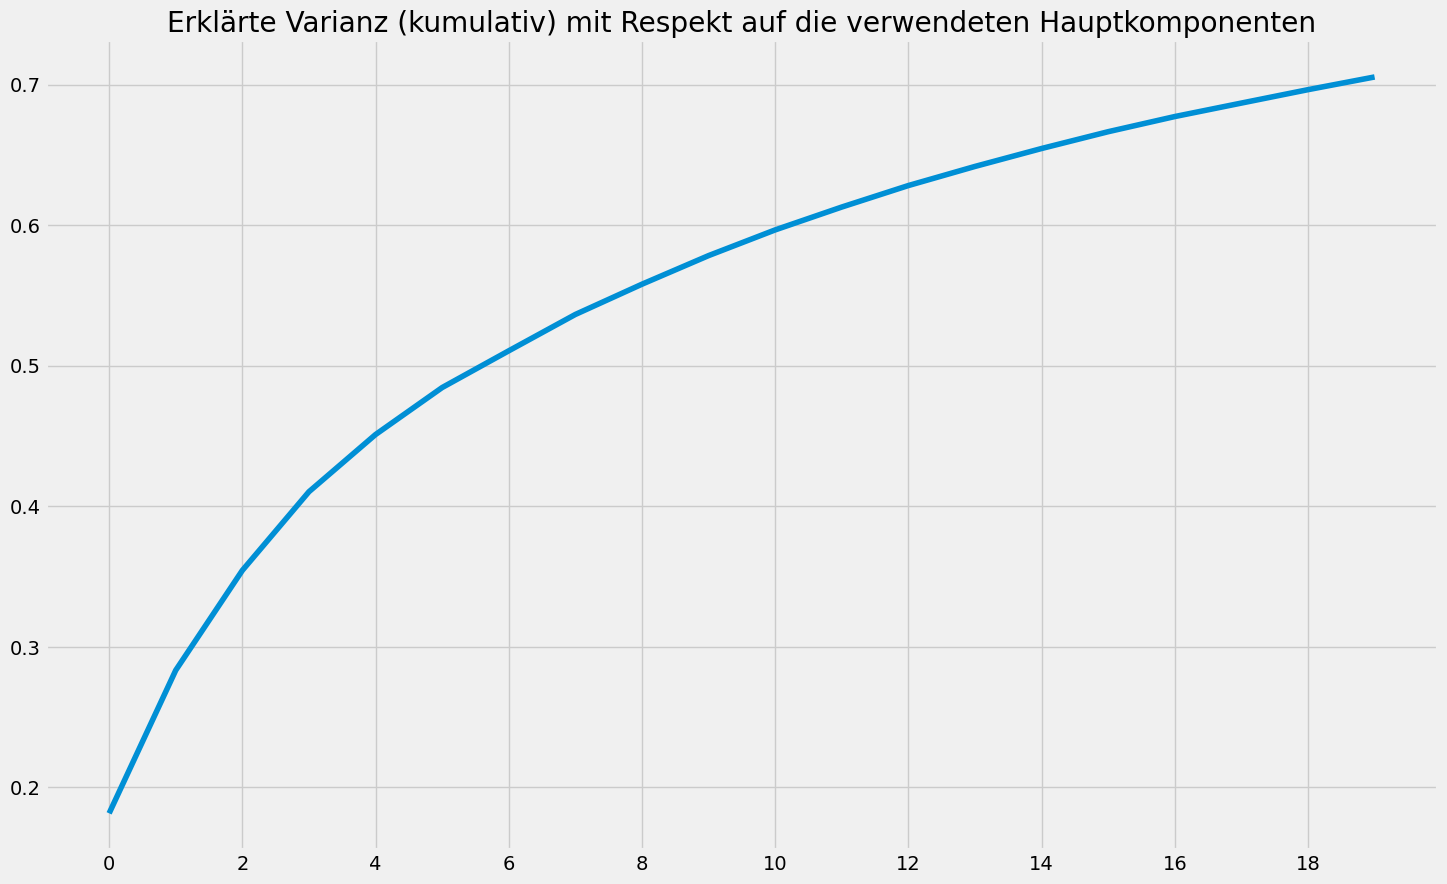

In [20]:
plt.figure(figsize=(16, 10))
plt.title('Erklärte Varianz (kumulativ) mit Respekt auf die verwendeten Hauptkomponenten')
plt.plot(pca_model_centered.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 20, step=2))

Mit allen Komponenten

([<matplotlib.axis.XTick at 0x3195896a0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20'),
  Text(22, 0, '22'),
  Text(24, 0, '24'),
  Text(26, 0, '26'),
  Text(28, 0, '28'),
  Text(30, 0, '30'),
  Text(32, 0, '32'),
  Text(34, 0, '34'),
  Text(36, 0, '36'),
  Text(38, 0, '38'),
  Text(40, 0, '40'),
  Text(42, 0, '42'),
  Text(44, 0, '44'),
  Text(46, 0, '46'),
  Text(48, 0, '48'),
  Text(50, 0, '50'),
  Text(52, 0, '52'),
  Text(54, 0, '54'),
  Text(56, 0, '56'),
  Text(58, 0, '58'),
  Text(60, 0, '60'),
  Text(62, 0, '62'),
  Text(64, 0, '64'),
  Text(66, 0, '66'),
  Text(68, 0, '68'),
  Text(70, 0, '70'),
  Text(72, 0, '72'),
  Text(74, 0, '74'),
  Text(76, 0, '76'),
  Text(78, 0, '78'),
  Text(80, 0, '80'),
  Text(82, 0, '82'),
  Text(84, 0, '84'),
  Text(86, 0, '86'),
  Text(88, 0, '88'),
  Text(90, 0, '90'),
  

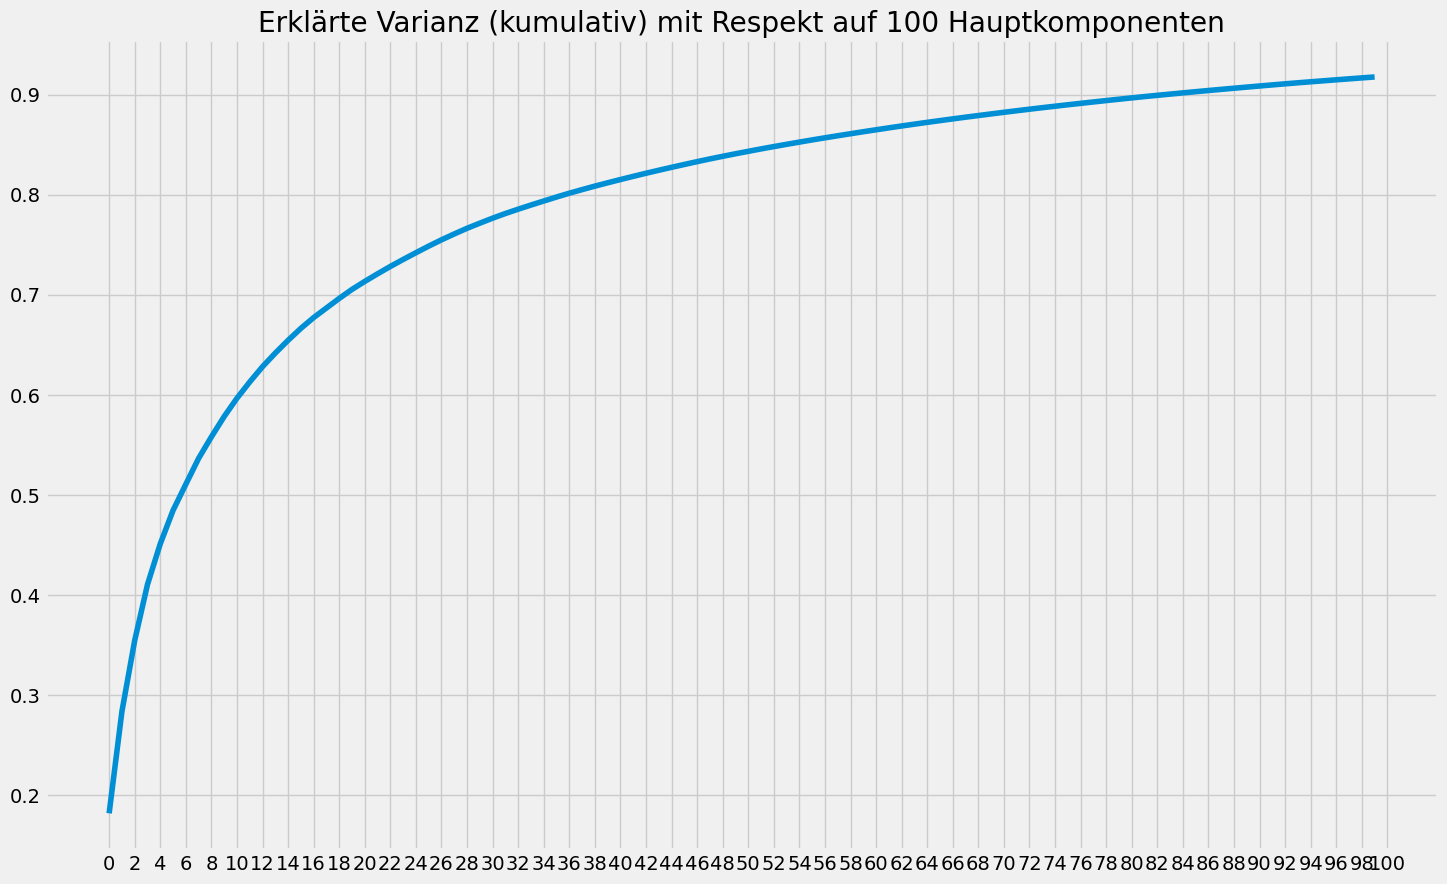

In [21]:
all_comp_pca = PCA(100)
all_comp_pca.fit_transform(faces_centered)

plt.figure(figsize=(16, 10))
plt.title('Erklärte Varianz (kumulativ) mit Respekt auf 100 Hauptkomponenten')
plt.plot(all_comp_pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 101, step=2))

## b) Inverse Transformation

Berechne eine PCA und plotte die Rekonstruktion von 5 Gesichter basierend auf $5, 10, 20, 50, 100, 200, 300$ und $ 400$ Hauptkomponenten. Dazu kannst du die Methode `inverse_transform` benutzen.

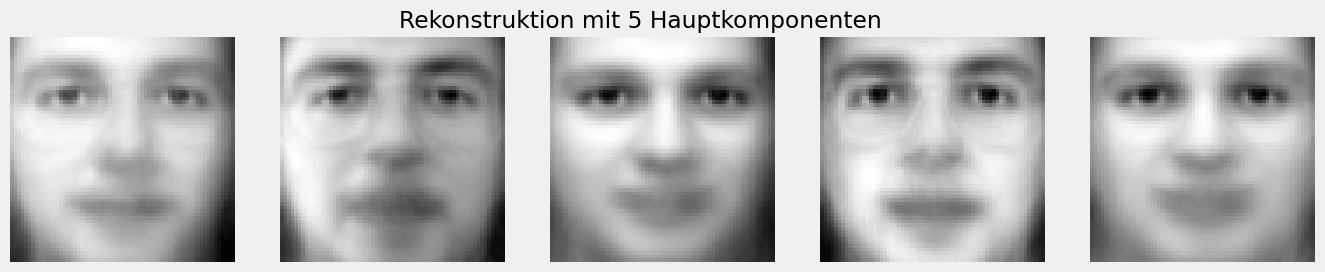

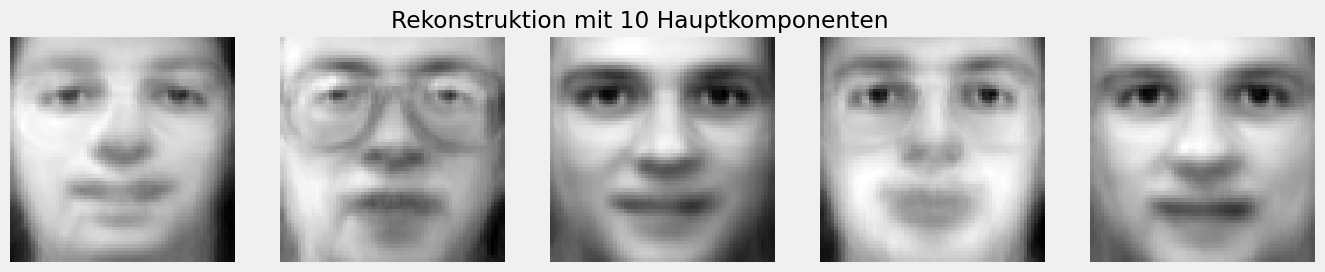

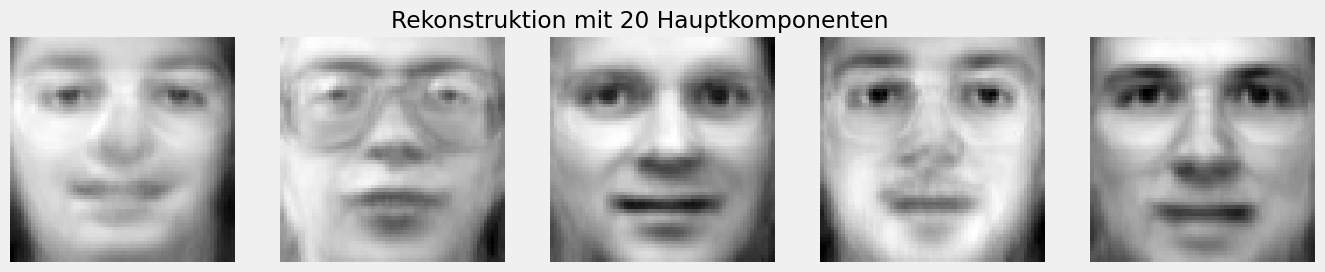

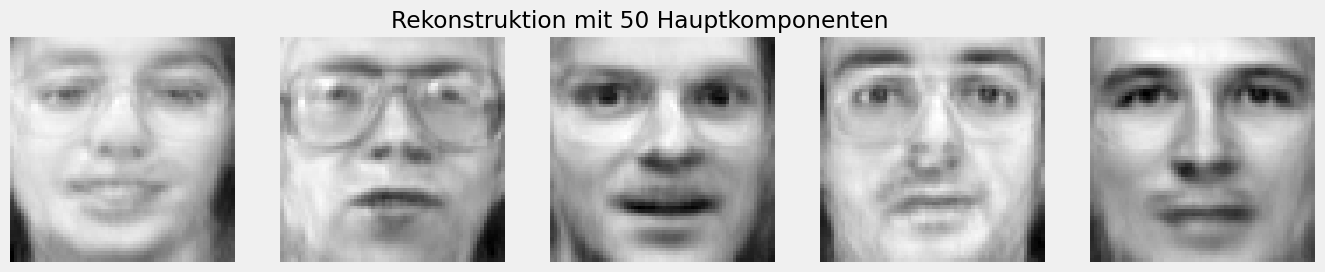

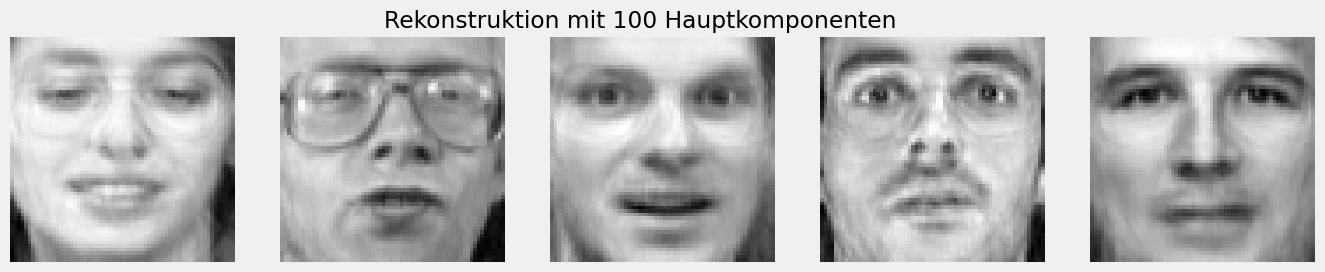

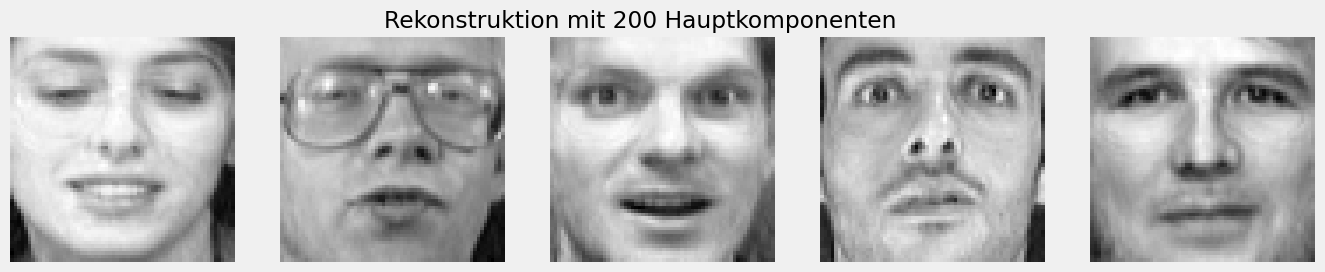

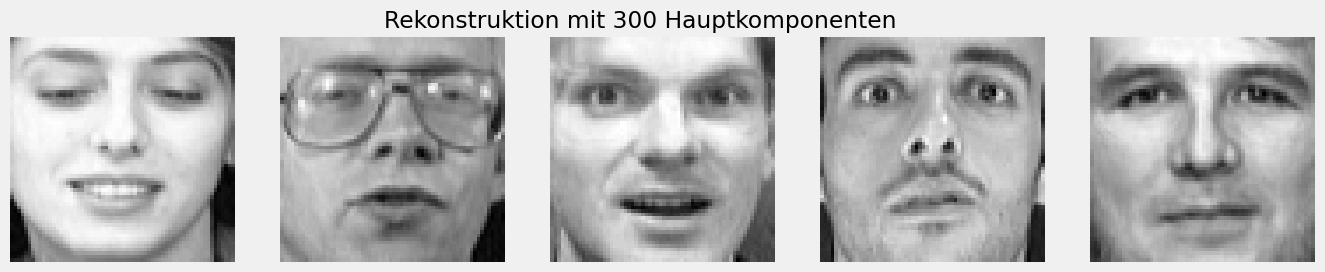

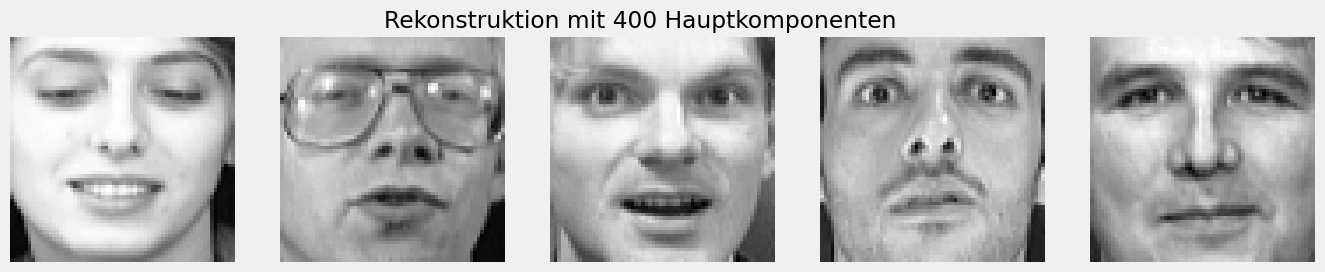

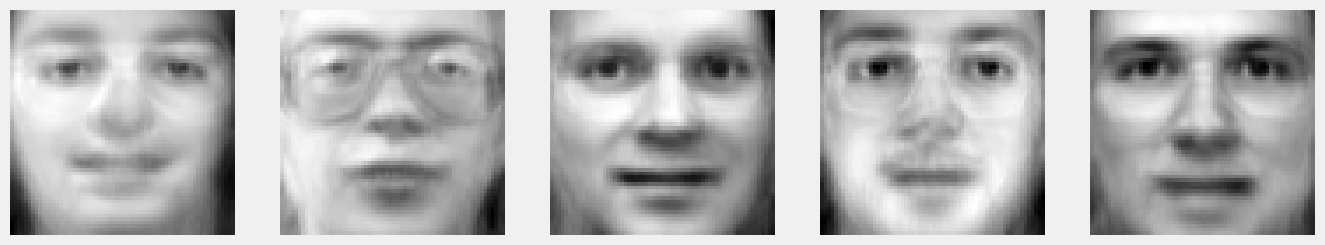

In [43]:
import random
random.seed(42)
rnd_ind = idx[random.sample(range(len(idx)), 5)]

n_comp_list = [5, 10, 20, 50, 100, 200, 300, 400]
for n_comp in n_comp_list:
    pca_temp = PCA(n_components=n_comp)
    faces_transformed_temp = pca_temp.fit_transform(faces)

    faces_recovered_temp = pca_temp.inverse_transform(faces_transformed_temp)
    plot_faces(faces_recovered_temp[rnd_ind], cols=5, title=f"Rekonstruktion mit {str(n_comp)} Hauptkomponenten")
    
pca_temp = PCA(n_components=20)
faces_transformed_temp = pca_temp.fit_transform(faces)
faces_recovered_temp = pca_temp.inverse_transform(faces_transformed_temp)
fig, _ = plot_faces(faces_recovered_temp[rnd_ind], cols=5)
fig.savefig("faces_reconstructed_pca_with_20-main-components.png", dpi=900)


## c) Feature Importance
- Berechne die *Gini Feature Importance*. Du kannst `imshow` für die Visualisierung verwenden.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces, labels, test_size=0.2, stratify=labels, random_state=42)

In [ ]:
rf_clf = RandomForestClassifier( n_estimators =100 , random_state=42)
rf_clf.fit(X_train, y_train)
feature_imps = []
for name, score in zip(list(range(X_train.shape[1])), rf_clf.feature_importances_):
    feature_imps.append(score)
    print(name, score)

(-0.5, 63.5, 63.5, -0.5)

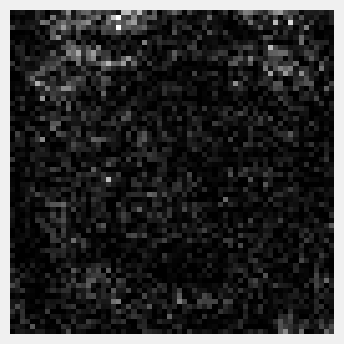

In [25]:
feature_imps = np.array(feature_imps)
plt.figure(figsize=(4,4))
plt.imshow(feature_imps.reshape(64,64), cmap="gray")
plt.axis("off")


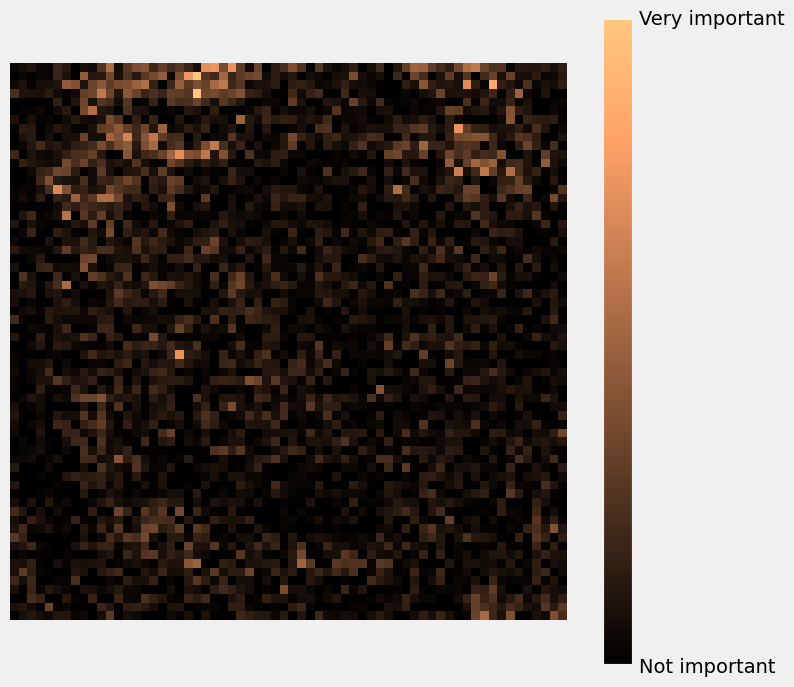

In [40]:
def plot_digit(data):
    plt.figure(figsize=(8,8))
    image = data.reshape(64, 64)
    plt.imshow(image, interpolation="nearest", cmap="copper")
    plt.axis("off")
    
plot_digit(feature_imps)

cbar = plt.colorbar(ticks=[feature_imps.min(), feature_imps.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.savefig("feature_importance.png", dpi=900)
plt.show()


## d) Gesichtserkennung

Erstelle ein Modell zur Gesichtserkennung. Du kannst dazu Methoden deiner Wahl verwenden. Experimentiere mit verschiedenen Modellen (`SVC`, `RandomForestClassifier`, ...). 
- Erstelle auch einen `VotingClassifier` basierend auf verschiedenen Modellen. 
- Probiere auch eine `PCA` als Preprocessingschritt. Was macht der Parameter `whiten` in der PCA?
- Wie hoch ist der Accuracy Score auf dem Trainings- und Testset? Kannst du einen Score von 1 auf dem Testset erreichen? Falls nicht, welche Personen werden verwechselt? Plotte die Geichter dieser Personen.


-> `whiten` entfernt etwas die Korrelation zwischen den Komponenten mit der Multiplikation durch die Wurzel der Anzahl der Beobactungen und Division durch die Singulärwerte. Also, etwas "Information" wird durch diese Operation verloren aber durch den erhöhten "Kontrast" können die Klassifikationen besser funktionieren. Die Bespiele sind unten.  

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn . svm import LinearSVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

Scaling/preprocessing:
* StandartScaler
* PCA (Anzahl der Hauptachsen durch Horn's oder Elbow zu berechnen)

Modelle:

* Log. Reg.
* Regular SVM
* RBF Kernel SVM
* K Neighbors
* Adaboost
* Random Forrest Classifier

Durch Votingclassifier

In [28]:
n_comp = 120 
gamma_cand = np.arange(0.01, 10, 1)
c_cand = [0.1, 1, 10, 100]
svm_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, whiten=True)),
                ('svc', SVC(kernel='rbf', probability=True))])


svm_param_cv = GridSearchCV(svm_pipe, {"svc__C": c_cand, "svc__gamma": gamma_cand}, cv=5) 
svm_param_cv.fit(X_train, y_train)

# save the best estimator as svm_pipe (best C=10, best gamma=0.01)
svm_pipe = svm_param_cv.best_estimator_

In [29]:
n_estimator_cand = np.arange(100, 400, 50)
ada_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, whiten=True)),
                ('ada', AdaBoostClassifier(DecisionTreeClassifier(max_depth = 50),algorithm = "SAMME.R" , learning_rate=0.5))])

ada_param_cv = GridSearchCV(ada_pipe, {"ada__n_estimators": n_estimator_cand}, cv=5) 
ada_param_cv.fit(X_train, y_train)

# save the best estimator as ada_pipe (n_estimators = 200)
ada_pipe = ada_param_cv.best_estimator_

In [30]:
reg_svm_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, whiten=True)),
                ('svc', SVC(probability=True))])
log_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, whiten=True)),
                ('log', LogisticRegression(solver="newton-cg"))])
knn_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, whiten=True)),
                ('knc', KNeighborsClassifier(3))])
rf_pipe = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=n_comp, whiten=True)),
                ('clf', RandomForestClassifier())])

log_pipe.fit(X_train, y_train) 
reg_svm_pipe.fit(X_train, y_train)
ada_pipe.fit(X_train, y_train) 
svm_pipe.fit(X_train, y_train) 
knn_pipe.fit(X_train, y_train) 
rf_pipe.fit(X_train, y_train) 

model_list = [log_pipe,
              reg_svm_pipe,
              ada_pipe,
              svm_pipe,
              knn_pipe,
              rf_pipe]

In [31]:
model_name_list = ["Logistic Reg.", 
                    "Reg. SVM",
                    "AdaBoost",
                    "Support Vector M.",
                    "K Neighbor Classifier",
                    "Random Forest"]
for i,mod in enumerate(model_list):
    y_pred = mod.predict(X_test)
    acc_scr = accuracy_score(y_test, y_pred)
    print(f"Accuracy score of {model_name_list[i]} = {acc_scr}")


Accuracy score of Logistic Reg. = 0.9875
Accuracy score of Reg. SVM = 0.9875
Accuracy score of AdaBoost = 0.525
Accuracy score of Support Vector M. = 0.9875
Accuracy score of K Neighbor Classifier = 0.7625
Accuracy score of Random Forest = 0.925


Finale Version.

In [32]:
voting_clf = VotingClassifier ( estimators = list(zip(model_name_list, model_list)) ,
                                voting = 'soft',
                                weights=[2, 4, 0, 4, 0, 3])

voting_clf.fit( X_train , y_train )
y_pred = voting_clf.predict(X_test)
voting_clf_score = accuracy_score(y_test, y_pred)
print(f"Accuracy score of the voting classifier = {voting_clf_score}")

Accuracy score of the voting classifier = 0.9875


Welche Gesichte sind vom Model nicht erkennbar?

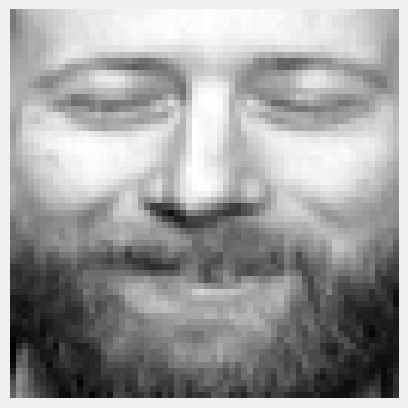

In [33]:
fail_ind = [i for i,x in enumerate(y_pred) if y_pred[i] != y_test[i]]
fail_face = X_test[fail_ind]
_plot_face(fail_face)


Wer glaubt das Modell er wäre?

(<Figure size 1200x300 with 4 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

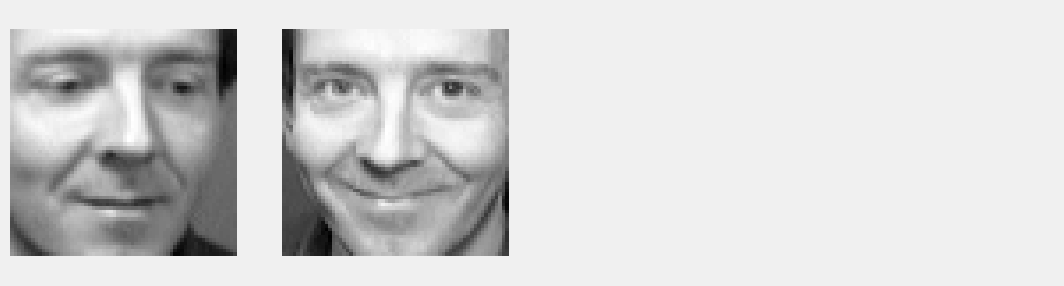

In [34]:
false_pos = [x for i,x in enumerate(y_pred) if y_pred[i] != y_test[i]]
false_pred_ind = [i for i,x in enumerate(y_test) if y_test[i] == false_pos]
false_pred_face = X_test[false_pred_ind]
plot_faces(false_pred_face)

Wie gut funktioniert das Modell mit anderen Datensätze?

In [35]:
from sklearn import datasets
lfw = datasets.fetch_lfw_people(min_faces_per_person = 100 ,resize =0.4) 

In [36]:
lfw.data.shape

(1140, 1850)

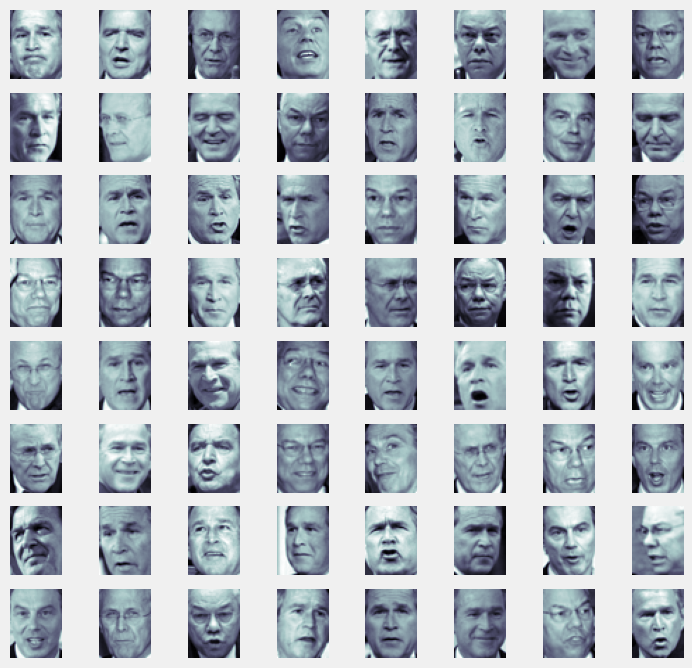

In [37]:
fig = plt.figure(figsize = (8,8))
for i in range(64):
    ax = fig.add_subplot(8,8,i+1)
    ax.imshow(lfw.images[i] , cmap = plt.cm.bone)
    plt.axis("off")

plt.show()


In [38]:
x , y = lfw.data , lfw.target
X_train2, X_test2, y_train2, y_test2 = train_test_split(x,y,random_state = 0)

In [39]:
voting_clf.fit( X_train2 , y_train2 )
y_pred2 = voting_clf.predict(X_test2)
voting_clf_score = accuracy_score(y_test2, y_pred2)
print(f"Accuracy score of the voting classifier = {voting_clf_score}")

/Users/ubd/miniforge3/envs/data_science/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/ubd/miniforge3/envs/data_science/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Accuracy score of the voting classifier = 0.9087719298245615


~91% accuracy, nicht schlecht